# Getting started with MLflow
Emanuel Tomé\
May 2024

## 1. Load packages

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
import mlflow

In [3]:
# mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/27 14:38:33 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/mlflow/artifacts/2', creation_time=1716817113013, experiment_id='2', last_update_time=1716817113013, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## 2. Q1 - Downloading the data

In [6]:
def read_data(filename: str) -> pd.DataFrame:
    "Function to read parquet file"
    return pd.read_parquet(filename)

january_data = read_data('../../data/green_tripdata_2023-01.parquet')
february_data = read_data('../../data/green_tripdata_2023-02.parquet')


In [7]:
january_data.shape

(68211, 20)

In [8]:
january_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00


## 3. Q2 - Computing duration

In [9]:
def compute_duration(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to compute duration"
    dataframe['duration'] = (
        dataframe['lpep_dropoff_datetime'] - dataframe['lpep_pickup_datetime']
        ).dt.total_seconds()/60
    return dataframe

january_data = compute_duration(january_data)
february_data = compute_duration(february_data)

In [10]:
january_data['duration'].std()

74.92563122537358

In [11]:
january_data['duration'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    68211.000000
mean        18.097271
std         74.925631
min          0.000000
1%           0.083333
5%           3.000000
50%         11.400000
95%         33.266667
99%         58.115000
max       1439.883333
Name: duration, dtype: float64

## 4. Q3 - Dropping outliers

In [12]:
def drop_outliers(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to drop outliers"
    return dataframe[(dataframe['duration'] >= 1) & (dataframe['duration'] <= 60)]

In [13]:
january_data_without_outliers = drop_outliers(january_data)
february_data_without_outliers = drop_outliers(february_data)

In [14]:
january_data_without_outliers.shape[0] / january_data.shape[0] * 100


96.6794212077231

In [15]:
february_data_without_outliers.shape[0] / february_data.shape[0] * 100

96.55140489746795

In [16]:
# from sklearn.model_selection import train_test_split

# # Assuming 'column_name' is the column you want to stratify by
# _, january_data_without_outliers = train_test_split(january_data_without_outliers,
#                                                     test_size=0.2,
#                                                     stratify=january_data_without_outliers['duration'],
#                                                     random_state=42)
# _, february_data_without_outliers = train_test_split(february_data_without_outliers,
#                                                      test_size=0.2,
#                                                      stratify=february_data_without_outliers['duration'],
#                                                      random_state=42)

## 5. Q4 - One-hot encoding

In [17]:
def cast_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to cast metrics"
    categorical = ['PULocationID', 'DOLocationID']
    dataframe[categorical] = dataframe[categorical].astype('str')
    return dataframe

In [18]:
january_data_without_outliers = cast_metrics(january_data_without_outliers)
february_data_without_outliers = cast_metrics(february_data_without_outliers)

/tmp/ipykernel_76596/3720923630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[categorical] = dataframe[categorical].astype('str')
/tmp/ipykernel_76596/3720923630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[categorical] = dataframe[categorical].astype('str')


In [19]:
def select_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to select metrics"
    # Definition of metrics
    categorical = ['PULocationID', 'DOLocationID'] #['PU_DO',]
    numerical = ['trip_distance',]
    
    # Join metrics
    dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']
    
    # Select variables
    filtered_df = dataframe[numerical + categorical].copy()
    
    return filtered_df

In [20]:
train_df = select_metrics(january_data_without_outliers)
test_df = select_metrics(february_data_without_outliers)


/tmp/ipykernel_76596/470491184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']
/tmp/ipykernel_76596/470491184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']


In [21]:
# Apply one hot encoding
vec = DictVectorizer()
train_dicts = train_df.to_dict(orient='records')
test_dicts = test_df.to_dict(orient='records')

X_train = vec.fit_transform(train_dicts).toarray()


In [22]:

X_test = vec.transform(test_dicts).toarray()

In [23]:
X_train.shape

(65946, 468)

In [24]:
y_train = january_data_without_outliers['duration']
y_test = february_data_without_outliers['duration']

## 6. Q5 - Training a model

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

In [27]:
# Save the model
with open('../models/lin_reg_green.bin', 'wb') as f:
    pickle.dump((vec, lr), f)

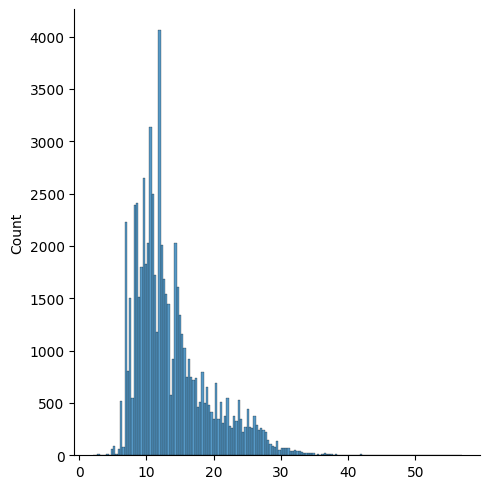

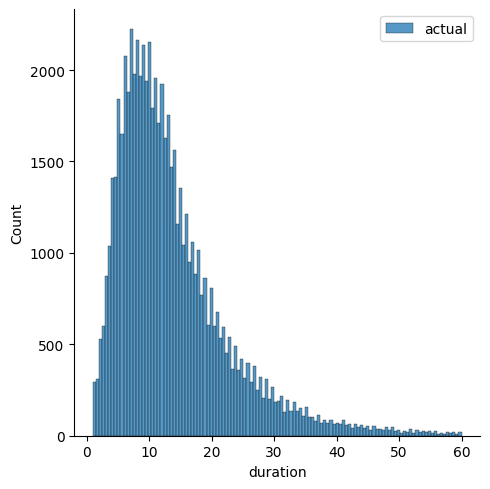

In [28]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [29]:
y_pred[y_pred < 1] = 1
y_pred[y_pred > 60] = 60

In [30]:
root_mean_squared_error(y_train, y_pred)

7.039887646604602

In [31]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Emanuel Tomé")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("test-data-path", "./data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    # Lasso
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_train)

    rmse = root_mean_squared_error(y_train, y_pred_lasso)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="../models/lin_reg_green.bin",
                        artifact_path="models_pickle")

## 7. Q6 - Evaluating the model

In [32]:
y_test_pred = lr.predict(X_test)

In [33]:
y_test_pred[y_test_pred < 1] = 1
y_test_pred[y_test_pred > 60] = 60

In [34]:
root_mean_squared_error(y_test.values, y_test_pred)

7.394465618971251

---
## 8. hyperopt

In [35]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)


In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(test, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(test)
        rmse = root_mean_squared_error(y_test, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [38]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:39:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86442                           
[1]	validation-rmse:8.44973                           
[2]	validation-rmse:8.07488                           
[3]	validation-rmse:7.73814                           
[4]	validation-rmse:7.43463                           
[5]	validation-rmse:7.16219                           
[6]	validation-rmse:6.91820                           
[7]	validation-rmse:6.70027                           
[8]	validation-rmse:6.50761                           
[9]	validation-rmse:6.33594                           
[10]	validation-rmse:6.18402                          
[11]	validation-rmse:6.05005                          
[12]	validation-rmse:5.92964                          
[13]	validation-rmse:5.82690                          
[14]	validation-rmse:5.73493                          
[15]	validation-rmse:5.65583                          
[16]	validation-rmse:5.58609                          
[17]	validation-rmse:5.52532                          
[18]	valid

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:39:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.20962                                                    
[6]	validation-rmse:5.19251                                                    
[7]	validation-rmse:5.17018                                                    
[8]	validation-rmse:5.14974                                                    
[9]	validation-rmse:5.14011                                                    
[10]	validation-rmse:5.13011                                                   
[11]	validation-rmse:5.12598                                                   
[12]	validation-rmse:5.12004                                                   
[13]	validation-rmse:5.11290                                                   
[14]	validation-rmse:5.10749                                                   
[15]	validation-rmse:5.10210                                                   
[16]	validation-rmse:5.09645                                                   
[17]	validation-rmse:5.08911            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:39:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.39357                                                     
[1]	validation-rmse:5.29321                                                     
[2]	validation-rmse:5.30129                                                     
[3]	validation-rmse:5.31654                                                     
[4]	validation-rmse:5.32853                                                     
[5]	validation-rmse:5.33870                                                     
[6]	validation-rmse:5.34272                                                     
[7]	validation-rmse:5.35440                                                     
[8]	validation-rmse:5.36815                                                     
[9]	validation-rmse:5.36478                                                     
[10]	validation-rmse:5.37304                                                    
[11]	validation-rmse:5.39525                                                    
[12]	validation-rmse:5.40481

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:39:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.52659                                                     
[1]	validation-rmse:6.48382                                                     
[2]	validation-rmse:5.90957                                                     
[3]	validation-rmse:5.61112                                                     
[4]	validation-rmse:5.45714                                                     
[5]	validation-rmse:5.39205                                                     
[6]	validation-rmse:5.35643                                                     
[7]	validation-rmse:5.34872                                                     
[8]	validation-rmse:5.34836                                                     
[9]	validation-rmse:5.35195                                                     
[10]	validation-rmse:5.35820                                                    
[11]	validation-rmse:5.36621                                                    
[12]	validation-rmse:5.36869

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:40:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38909                                                     
[1]	validation-rmse:7.64038                                                     
[2]	validation-rmse:7.04854                                                     
[3]	validation-rmse:6.58420                                                     
[4]	validation-rmse:6.21959                                                     
[5]	validation-rmse:5.94823                                                     
[6]	validation-rmse:5.74180                                                     
[7]	validation-rmse:5.58933                                                     
[8]	validation-rmse:5.47501                                                     
[9]	validation-rmse:5.39177                                                     
[10]	validation-rmse:5.33207                                                    
[11]	validation-rmse:5.28902                                                    
[12]	validation-rmse:5.25585

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:40:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.16201                                                     
[6]	validation-rmse:5.14836                                                     
[7]	validation-rmse:5.15208                                                     
[8]	validation-rmse:5.14641                                                     
[9]	validation-rmse:5.14033                                                     
[10]	validation-rmse:5.14572                                                    
[11]	validation-rmse:5.14260                                                    
[12]	validation-rmse:5.14416                                                    
[13]	validation-rmse:5.13580                                                    
[14]	validation-rmse:5.13565                                                    
[15]	validation-rmse:5.13052                                                    
[16]	validation-rmse:5.13634                                                    
[17]	validation-rmse:5.13273

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:40:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.90674                                                     
[4]	validation-rmse:7.62628                                                     
[5]	validation-rmse:7.37119                                                     
[6]	validation-rmse:7.13963                                                     
[7]	validation-rmse:6.92964                                                     
[8]	validation-rmse:6.73933                                                     
[9]	validation-rmse:6.56814                                                     
[10]	validation-rmse:6.41262                                                    
[11]	validation-rmse:6.27408                                                    
[12]	validation-rmse:6.14880                                                    
[13]	validation-rmse:6.03680                                                    
[14]	validation-rmse:5.93524                                                    
[15]	validation-rmse:5.84484

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:40:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.87738                                                     
[1]	validation-rmse:8.47632                                                     
[2]	validation-rmse:8.11582                                                     
[3]	validation-rmse:7.78942                                                     
[4]	validation-rmse:7.49617                                                     
[5]	validation-rmse:7.23340                                                     
[6]	validation-rmse:6.99770                                                     
[7]	validation-rmse:6.78925                                                     
[8]	validation-rmse:6.60162                                                     
[9]	validation-rmse:6.43648                                                     
[10]	validation-rmse:6.29216                                                    
[11]	validation-rmse:6.16067                                                    
[12]	validation-rmse:6.04619

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:40:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.19181                                                     
[3]	validation-rmse:6.73691                                                     
[4]	validation-rmse:6.37707                                                     
[5]	validation-rmse:6.09246                                                     
[6]	validation-rmse:5.87119                                                     
[7]	validation-rmse:5.69650                                                     
[8]	validation-rmse:5.56126                                                     
[9]	validation-rmse:5.45511                                                     
[10]	validation-rmse:5.37476                                                    
[11]	validation-rmse:5.30938                                                    
[12]	validation-rmse:5.25850                                                    
[13]	validation-rmse:5.21844                                                    
[14]	validation-rmse:5.18721

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.10622                                                   
[4]	validation-rmse:5.81092                                                   
[5]	validation-rmse:5.59947                                                   
[6]	validation-rmse:5.46153                                                   
[7]	validation-rmse:5.37009                                                   
[8]	validation-rmse:5.30118                                                   
[9]	validation-rmse:5.25736                                                   
[10]	validation-rmse:5.22397                                                  
[11]	validation-rmse:5.19699                                                  
[12]	validation-rmse:5.18290                                                  
[13]	validation-rmse:5.17158                                                  
[14]	validation-rmse:5.16185                                                  
[15]	validation-rmse:5.15338                        

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.24104                                                    
[2]	validation-rmse:5.67320                                                    
[3]	validation-rmse:5.39586                                                    
[4]	validation-rmse:5.26967                                                    
[5]	validation-rmse:5.21809                                                    
[6]	validation-rmse:5.19245                                                    
[7]	validation-rmse:5.18509                                                    
[8]	validation-rmse:5.18694                                                    
[9]	validation-rmse:5.18161                                                    
[10]	validation-rmse:5.18239                                                   
[11]	validation-rmse:5.18578                                                   
[12]	validation-rmse:5.18387                                                   
[13]	validation-rmse:5.18249            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.74031                                                    
[2]	validation-rmse:5.38780                                                    
[3]	validation-rmse:5.28006                                                    
[4]	validation-rmse:5.23945                                                    
[5]	validation-rmse:5.22715                                                    
[6]	validation-rmse:5.21837                                                    
[7]	validation-rmse:5.22206                                                    
[8]	validation-rmse:5.23111                                                    
[9]	validation-rmse:5.23901                                                    
[10]	validation-rmse:5.23363                                                   
[11]	validation-rmse:5.23630                                                   
[12]	validation-rmse:5.23901                                                   
[13]	validation-rmse:5.24352            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.27857                                                    
[2]	validation-rmse:6.63780                                                    
[3]	validation-rmse:6.17546                                                    
[4]	validation-rmse:5.84958                                                    
[5]	validation-rmse:5.62610                                                    
[6]	validation-rmse:5.47743                                                    
[7]	validation-rmse:5.37774                                                    
[8]	validation-rmse:5.31802                                                    
[9]	validation-rmse:5.27855                                                    
[10]	validation-rmse:5.24772                                                   
[11]	validation-rmse:5.23719                                                   
[12]	validation-rmse:5.22866                                                   
[13]	validation-rmse:5.22439            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.21911                                                    
[1]	validation-rmse:7.39816                                                    
[2]	validation-rmse:6.78761                                                    
[3]	validation-rmse:6.35340                                                    
[4]	validation-rmse:6.04982                                                    
[5]	validation-rmse:5.83960                                                    
[6]	validation-rmse:5.69329                                                    
[7]	validation-rmse:5.60840                                                    
[8]	validation-rmse:5.55528                                                    
[9]	validation-rmse:5.51913                                                    
[10]	validation-rmse:5.50029                                                   
[11]	validation-rmse:5.49103                                                   
[12]	validation-rmse:5.48607            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.42253                                                    
[4]	validation-rmse:7.08915                                                    
[5]	validation-rmse:6.80473                                                    
[6]	validation-rmse:6.55706                                                    
[7]	validation-rmse:6.34660                                                    
[8]	validation-rmse:6.16741                                                    
[9]	validation-rmse:6.00781                                                    
[10]	validation-rmse:5.87645                                                   
[11]	validation-rmse:5.76101                                                   
[12]	validation-rmse:5.66507                                                   
[13]	validation-rmse:5.58283                                                   
[14]	validation-rmse:5.51483                                                   
[15]	validation-rmse:5.45600            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56683                                                     
[1]	validation-rmse:6.51388                                                     
[2]	validation-rmse:5.91715                                                     
[3]	validation-rmse:5.57666                                                     
[4]	validation-rmse:5.40629                                                     
[5]	validation-rmse:5.31950                                                     
[6]	validation-rmse:5.27107                                                     
[7]	validation-rmse:5.25120                                                     
[8]	validation-rmse:5.24255                                                     
[9]	validation-rmse:5.23851                                                     
[10]	validation-rmse:5.23393                                                    
[11]	validation-rmse:5.23792                                                    
[12]	validation-rmse:5.23369

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.21997                                                     
[3]	validation-rmse:5.16174                                                     
[4]	validation-rmse:5.14032                                                     
[5]	validation-rmse:5.13018                                                     
[6]	validation-rmse:5.11690                                                     
[7]	validation-rmse:5.11333                                                     
[8]	validation-rmse:5.10537                                                     
[9]	validation-rmse:5.10578                                                     
[10]	validation-rmse:5.09758                                                    
[11]	validation-rmse:5.09697                                                    
[12]	validation-rmse:5.10072                                                    
[13]	validation-rmse:5.10483                                                    
[14]	validation-rmse:5.10273

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:41:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.39234                                                     
[1]	validation-rmse:6.32615                                                     
[2]	validation-rmse:5.77140                                                     
[3]	validation-rmse:5.50143                                                     
[4]	validation-rmse:5.37398                                                     
[5]	validation-rmse:5.31817                                                     
[6]	validation-rmse:5.29752                                                     
[7]	validation-rmse:5.29023                                                     
[8]	validation-rmse:5.29321                                                     
[9]	validation-rmse:5.29551                                                     
[10]	validation-rmse:5.29880                                                    
[11]	validation-rmse:5.30047                                                    
[12]	validation-rmse:5.30139

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:42:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.15425                                                     
[4]	validation-rmse:5.10941                                                     
[5]	validation-rmse:5.09446                                                     
[6]	validation-rmse:5.08046                                                     
[7]	validation-rmse:5.07758                                                     
[8]	validation-rmse:5.07524                                                     
[9]	validation-rmse:5.07102                                                     
[10]	validation-rmse:5.06910                                                    
[11]	validation-rmse:5.06550                                                    
[12]	validation-rmse:5.06398                                                    
[13]	validation-rmse:5.06298                                                    
[14]	validation-rmse:5.06222                                                    
[15]	validation-rmse:5.06112

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:42:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.14754                                                     
[1]	validation-rmse:5.43638                                                     
[2]	validation-rmse:5.33918                                                     
[3]	validation-rmse:5.34922                                                     
[4]	validation-rmse:5.35822                                                     
[5]	validation-rmse:5.37327                                                     
[6]	validation-rmse:5.38707                                                     
[7]	validation-rmse:5.39875                                                     
[8]	validation-rmse:5.40829                                                     
[9]	validation-rmse:5.41277                                                     
[10]	validation-rmse:5.42146                                                    
[11]	validation-rmse:5.43178                                                    
[12]	validation-rmse:5.43414

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:42:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.02117
[5]	validation-rmse:6.75510                                                     
[6]	validation-rmse:6.53151                                                     
[7]	validation-rmse:6.34464                                                     
[8]	validation-rmse:6.19094                                                     
[9]	validation-rmse:6.06479                                                     
[10]	validation-rmse:5.95852                                                    
[11]	validation-rmse:5.87104                                                    
[12]	validation-rmse:5.79676                                                    
[13]	validation-rmse:5.73485                                                    
[14]	validation-rmse:5.68465                                                    
[15]	validation-rmse:5.64339                                                    
[16]	validation-rmse:5.60658                                                    


/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:42:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.18655                                                     
[2]	validation-rmse:7.72562                                                     
[3]	validation-rmse:7.32571                                                     
[4]	validation-rmse:6.98064                                                     
[5]	validation-rmse:6.68394                                                     
[6]	validation-rmse:6.42977                                                     
[7]	validation-rmse:6.21259                                                     
[8]	validation-rmse:6.02989                                                     
[9]	validation-rmse:5.87416                                                     
[10]	validation-rmse:5.74400                                                    
[11]	validation-rmse:5.63562                                                    
[12]	validation-rmse:5.54439                                                    
[13]	validation-rmse:5.46911

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:43:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.52302                                                     
[7]	validation-rmse:6.33046                                                     
[8]	validation-rmse:6.16907                                                     
[9]	validation-rmse:6.03444                                                     
[10]	validation-rmse:5.92050                                                    
[11]	validation-rmse:5.82662                                                    
[12]	validation-rmse:5.74866                                                    
[13]	validation-rmse:5.68270                                                    
[14]	validation-rmse:5.62788                                                    
[15]	validation-rmse:5.58021                                                    
[16]	validation-rmse:5.54225                                                    
[17]	validation-rmse:5.50862                                                    
[18]	validation-rmse:5.47910

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:43:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.83907                                                    
[6]	validation-rmse:7.64847                                                    
[7]	validation-rmse:7.47134                                                    
[8]	validation-rmse:7.30765                                                    
[9]	validation-rmse:7.15665                                                    
[10]	validation-rmse:7.01623                                                   
[11]	validation-rmse:6.88590                                                   
[12]	validation-rmse:6.76725                                                   
[13]	validation-rmse:6.65735                                                   
[14]	validation-rmse:6.55545                                                   
[15]	validation-rmse:6.46156                                                   
[16]	validation-rmse:6.37568                                                   
[17]	validation-rmse:6.29574            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:44:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.72738                                                    
[3]	validation-rmse:7.33353                                                    
[4]	validation-rmse:6.99653                                                    
[5]	validation-rmse:6.71061                                                    
[6]	validation-rmse:6.46476                                                    
[7]	validation-rmse:6.25672                                                    
[8]	validation-rmse:6.08179                                                    
[9]	validation-rmse:5.93245                                                    
[10]	validation-rmse:5.80915                                                   
[11]	validation-rmse:5.70426                                                   
[12]	validation-rmse:5.61441                                                   
[13]	validation-rmse:5.54178                                                   
[14]	validation-rmse:5.47824            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:45:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.98764                                                    
[5]	validation-rmse:7.77314                                                    
[6]	validation-rmse:7.57324                                                    
[7]	validation-rmse:7.38856                                                    
[8]	validation-rmse:7.21802                                                    
[9]	validation-rmse:7.05962                                                    
[10]	validation-rmse:6.91294                                                   
[11]	validation-rmse:6.77860                                                   
[12]	validation-rmse:6.65440                                                   
[13]	validation-rmse:6.53966                                                   
[14]	validation-rmse:6.43433                                                   
[15]	validation-rmse:6.33817                                                   
[16]	validation-rmse:6.24733            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:46:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.99378                                                    
[5]	validation-rmse:7.77998                                                    
[6]	validation-rmse:7.58103                                                    
[7]	validation-rmse:7.39655                                                    
[8]	validation-rmse:7.22587                                                    
[9]	validation-rmse:7.06727                                                    
[10]	validation-rmse:6.92203                                                   
[11]	validation-rmse:6.78633                                                   
[12]	validation-rmse:6.66235                                                   
[13]	validation-rmse:6.54820                                                   
[14]	validation-rmse:6.44259                                                   
[15]	validation-rmse:6.34523                                                   
[16]	validation-rmse:6.25557            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:47:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.31136                                                    
[3]	validation-rmse:8.02586                                                    
[4]	validation-rmse:7.76237                                                    
[5]	validation-rmse:7.52076                                                    
[6]	validation-rmse:7.29960                                                    
[7]	validation-rmse:7.09728                                                    
[8]	validation-rmse:6.91131                                                    
[9]	validation-rmse:6.74168                                                    
[10]	validation-rmse:6.58724                                                   
[11]	validation-rmse:6.44701                                                   
[12]	validation-rmse:6.31970                                                   
[13]	validation-rmse:6.20343                                                   
[14]	validation-rmse:6.09771            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:48:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.12600                                                    
[3]	validation-rmse:7.81072                                                    
[4]	validation-rmse:7.53067                                                    
[5]	validation-rmse:7.28418                                                    
[6]	validation-rmse:7.06469                                                    
[7]	validation-rmse:6.87168                                                    
[8]	validation-rmse:6.70287                                                    
[9]	validation-rmse:6.55467                                                    
[10]	validation-rmse:6.42457                                                   
[11]	validation-rmse:6.30944                                                   
[12]	validation-rmse:6.20966                                                   
[13]	validation-rmse:6.12223                                                   
[14]	validation-rmse:6.04735            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:49:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.84594                                                    
[2]	validation-rmse:7.29405                                                    
[3]	validation-rmse:6.84176                                                    
[4]	validation-rmse:6.47553                                                    
[5]	validation-rmse:6.18335                                                    
[6]	validation-rmse:5.95136                                                    
[7]	validation-rmse:5.76403                                                    
[8]	validation-rmse:5.61839                                                    
[9]	validation-rmse:5.50331                                                    
[10]	validation-rmse:5.41233                                                   
[11]	validation-rmse:5.34235                                                   
[12]	validation-rmse:5.28817                                                   
[13]	validation-rmse:5.24541            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:49:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.01131                                                    
[3]	validation-rmse:7.66287                                                    
[4]	validation-rmse:7.35345                                                    
[5]	validation-rmse:7.07788                                                    
[6]	validation-rmse:6.83433                                                    
[7]	validation-rmse:6.61877                                                    
[8]	validation-rmse:6.42993                                                    
[9]	validation-rmse:6.26338                                                    
[10]	validation-rmse:6.11707                                                   
[11]	validation-rmse:5.98865                                                   
[12]	validation-rmse:5.87816                                                   
[13]	validation-rmse:5.78052                                                   
[14]	validation-rmse:5.69525            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:49:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.60596                                                    
[2]	validation-rmse:8.28834                                                    
[3]	validation-rmse:7.99670                                                    
[4]	validation-rmse:7.72875                                                    
[5]	validation-rmse:7.48285                                                    
[6]	validation-rmse:7.25733                                                    
[7]	validation-rmse:7.05116                                                    
[8]	validation-rmse:6.86203                                                    
[9]	validation-rmse:6.69054                                                    
[10]	validation-rmse:6.53510                                                   
[11]	validation-rmse:6.39204                                                   
[12]	validation-rmse:6.26231                                                   
[13]	validation-rmse:6.14497            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:49:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.48528                                                    
[3]	validation-rmse:7.06436                                                    
[4]	validation-rmse:6.72153                                                    
[5]	validation-rmse:6.43686                                                    
[6]	validation-rmse:6.20567                                                    
[7]	validation-rmse:6.02074                                                    
[8]	validation-rmse:5.86962                                                    
[9]	validation-rmse:5.74974                                                    
[10]	validation-rmse:5.65028                                                   
[11]	validation-rmse:5.56923                                                   
[12]	validation-rmse:5.50371                                                   
[13]	validation-rmse:5.45174                                                   
[14]	validation-rmse:5.40766            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:50:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74716                                                    
[1]	validation-rmse:6.71888                                                    
[2]	validation-rmse:6.06315                                                    
[3]	validation-rmse:5.67058                                                    
[4]	validation-rmse:5.43463                                                    
[5]	validation-rmse:5.28849                                                    
[6]	validation-rmse:5.20758                                                    
[7]	validation-rmse:5.15920                                                    
[8]	validation-rmse:5.13227                                                    
[9]	validation-rmse:5.11479                                                    
[10]	validation-rmse:5.10195                                                   
[11]	validation-rmse:5.09536                                                   
[12]	validation-rmse:5.09083            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:50:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.34115                                                    
[2]	validation-rmse:7.93192                                                    
[3]	validation-rmse:7.56946                                                    
[4]	validation-rmse:7.24841                                                    
[5]	validation-rmse:6.96744                                                    
[6]	validation-rmse:6.72053                                                    
[7]	validation-rmse:6.50539                                                    
[8]	validation-rmse:6.31789                                                    
[9]	validation-rmse:6.15328                                                    
[10]	validation-rmse:6.01117                                                   
[11]	validation-rmse:5.88728                                                   
[12]	validation-rmse:5.78029                                                   
[13]	validation-rmse:5.68868            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:50:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.09316                                                    
[3]	validation-rmse:6.63812                                                    
[4]	validation-rmse:6.28463                                                    
[5]	validation-rmse:6.00767                                                    
[6]	validation-rmse:5.79825                                                    
[7]	validation-rmse:5.64053                                                    
[8]	validation-rmse:5.51551                                                    
[9]	validation-rmse:5.42015                                                    
[10]	validation-rmse:5.34630                                                   
[11]	validation-rmse:5.29177                                                   
[12]	validation-rmse:5.24605                                                   
[13]	validation-rmse:5.21145                                                   
[14]	validation-rmse:5.18458            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:50:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.36326                                                    
[6]	validation-rmse:7.13671                                                    
[7]	validation-rmse:6.93306                                                    
[8]	validation-rmse:6.74931                                                    
[9]	validation-rmse:6.58714                                                    
[10]	validation-rmse:6.44114                                                   
[11]	validation-rmse:6.30955                                                   
[12]	validation-rmse:6.19216                                                   
[13]	validation-rmse:6.08878                                                   
[14]	validation-rmse:5.99614                                                   
[15]	validation-rmse:5.91360                                                   
[16]	validation-rmse:5.83949                                                   
[17]	validation-rmse:5.77435            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:51:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99176                                                    
[1]	validation-rmse:8.68420                                                    
[2]	validation-rmse:8.39830                                                    
[3]	validation-rmse:8.13241                                                    
[4]	validation-rmse:7.88436                                                    
[5]	validation-rmse:7.65585                                                    
[6]	validation-rmse:7.44221                                                    
[7]	validation-rmse:7.24574                                                    
[8]	validation-rmse:7.06417                                                    
[9]	validation-rmse:6.89580                                                    
[10]	validation-rmse:6.74086                                                   
[11]	validation-rmse:6.59749                                                   
[12]	validation-rmse:6.46609            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:51:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.84068                                                    
[3]	validation-rmse:6.37346                                                    
[4]	validation-rmse:6.02701                                                    
[5]	validation-rmse:5.77364                                                    
[6]	validation-rmse:5.58800                                                    
[7]	validation-rmse:5.45288                                                    
[8]	validation-rmse:5.35511                                                    
[9]	validation-rmse:5.28331                                                    
[10]	validation-rmse:5.23073                                                   
[11]	validation-rmse:5.18968                                                   
[12]	validation-rmse:5.16118                                                   
[13]	validation-rmse:5.14090                                                   
[14]	validation-rmse:5.12325            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:51:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.94124                                                    
[2]	validation-rmse:6.28459                                                    
[3]	validation-rmse:5.85295                                                    
[4]	validation-rmse:5.57663                                                    
[5]	validation-rmse:5.40210                                                    
[6]	validation-rmse:5.28361                                                    
[7]	validation-rmse:5.21318                                                    
[8]	validation-rmse:5.16259                                                    
[9]	validation-rmse:5.13324                                                    
[10]	validation-rmse:5.11245                                                   
[11]	validation-rmse:5.09823                                                   
[12]	validation-rmse:5.08785                                                   
[13]	validation-rmse:5.08471            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:52:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:7.06921                                                    
[9]	validation-rmse:6.91730                                                    
[10]	validation-rmse:6.77911                                                   
[11]	validation-rmse:6.65528                                                   
[12]	validation-rmse:6.54366                                                   
[13]	validation-rmse:6.44184                                                   
[14]	validation-rmse:6.35061                                                   
[15]	validation-rmse:6.26764                                                   
[16]	validation-rmse:6.19390                                                   
[17]	validation-rmse:6.12646                                                   
[18]	validation-rmse:6.06611                                                   
[19]	validation-rmse:6.01202                                                   
[20]	validation-rmse:5.96213            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:52:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.95936                                                    
[2]	validation-rmse:7.43371                                                    
[3]	validation-rmse:6.99605                                                    
[4]	validation-rmse:6.63280                                                    
[5]	validation-rmse:6.33425                                                    
[6]	validation-rmse:6.08917                                                    
[7]	validation-rmse:5.89226                                                    
[8]	validation-rmse:5.73428                                                    
[9]	validation-rmse:5.60300                                                    
[10]	validation-rmse:5.49961                                                   
[11]	validation-rmse:5.41716                                                   
[12]	validation-rmse:5.34899                                                   
[13]	validation-rmse:5.29558            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:52:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.44914                                                    
[5]	validation-rmse:6.16902                                                    
[6]	validation-rmse:5.95165                                                    
[7]	validation-rmse:5.78231                                                    
[8]	validation-rmse:5.65059                                                    
[9]	validation-rmse:5.54874                                                    
[10]	validation-rmse:5.46399                                                   
[11]	validation-rmse:5.39878                                                   
[12]	validation-rmse:5.34989                                                   
[13]	validation-rmse:5.30670                                                   
[14]	validation-rmse:5.27419                                                   
[15]	validation-rmse:5.24950                                                   
[16]	validation-rmse:5.22684            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.48566                                                    
[2]	validation-rmse:8.12545                                                    
[3]	validation-rmse:7.80010                                                    
[4]	validation-rmse:7.50663                                                    
[5]	validation-rmse:7.24320                                                    
[6]	validation-rmse:7.00700                                                    
[7]	validation-rmse:6.79555                                                    
[8]	validation-rmse:6.60546                                                    
[9]	validation-rmse:6.43632                                                    
[10]	validation-rmse:6.28523                                                   
[11]	validation-rmse:6.15192                                                   
[12]	validation-rmse:6.03290                                                   
[13]	validation-rmse:5.92809            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.29959                                                    
[2]	validation-rmse:7.87828                                                    
[3]	validation-rmse:7.50783                                                    
[4]	validation-rmse:7.18518                                                    
[5]	validation-rmse:6.90321                                                    
[6]	validation-rmse:6.65907                                                    
[7]	validation-rmse:6.44759                                                    
[8]	validation-rmse:6.26449                                                    
[9]	validation-rmse:6.10951                                                    
[10]	validation-rmse:5.97036                                                   
[11]	validation-rmse:5.85313                                                   
[12]	validation-rmse:5.75505                                                   
[13]	validation-rmse:5.67081            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:5.24000                                                    
[8]	validation-rmse:5.21367                                                    
[9]	validation-rmse:5.20454                                                    
[10]	validation-rmse:5.19416                                                   
[11]	validation-rmse:5.18679                                                   
[12]	validation-rmse:5.17665                                                   
[13]	validation-rmse:5.16375                                                   
[14]	validation-rmse:5.16200                                                   
[15]	validation-rmse:5.16074                                                   
[16]	validation-rmse:5.15382                                                   
[17]	validation-rmse:5.14812                                                   
[18]	validation-rmse:5.14423                                                   
[19]	validation-rmse:5.14275            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.50011                                                    
[3]	validation-rmse:6.04957                                                    
[4]	validation-rmse:5.74027                                                    
[5]	validation-rmse:5.52954                                                    
[6]	validation-rmse:5.38600                                                    
[7]	validation-rmse:5.29279                                                    
[8]	validation-rmse:5.22789                                                    
[9]	validation-rmse:5.18610                                                    
[10]	validation-rmse:5.15177                                                   
[11]	validation-rmse:5.12868                                                   
[12]	validation-rmse:5.11115                                                   
[13]	validation-rmse:5.09632                                                   
[14]	validation-rmse:5.08662            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.09954                                                    
[2]	validation-rmse:7.61357                                                    
[3]	validation-rmse:7.20226                                                    
[4]	validation-rmse:6.85158                                                    
[5]	validation-rmse:6.55655                                                    
[6]	validation-rmse:6.31049                                                    
[7]	validation-rmse:6.10275                                                    
[8]	validation-rmse:5.93361                                                    
[9]	validation-rmse:5.78939                                                    
[10]	validation-rmse:5.66995                                                   
[11]	validation-rmse:5.57217                                                   
[12]	validation-rmse:5.49433                                                   
[13]	validation-rmse:5.43056            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:53:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.45038                                                    
[3]	validation-rmse:5.27067                                                    
[4]	validation-rmse:5.18502                                                    
[5]	validation-rmse:5.14113                                                    
[6]	validation-rmse:5.11418                                                    
[7]	validation-rmse:5.09692                                                    
[8]	validation-rmse:5.08919                                                    
[9]	validation-rmse:5.08621                                                    
[10]	validation-rmse:5.07758                                                   
[11]	validation-rmse:5.07537                                                   
[12]	validation-rmse:5.06184                                                   
[13]	validation-rmse:5.05904                                                   
[14]	validation-rmse:5.05436            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:54:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.27192                                                    
[1]	validation-rmse:7.46459                                                    
[2]	validation-rmse:6.85742                                                    
[3]	validation-rmse:6.40534                                                    
[4]	validation-rmse:6.06948                                                    
[5]	validation-rmse:5.82836                                                    
[6]	validation-rmse:5.65589                                                    
[7]	validation-rmse:5.54099                                                    
[8]	validation-rmse:5.45101                                                    
[9]	validation-rmse:5.39435                                                    
[10]	validation-rmse:5.35335                                                   
[11]	validation-rmse:5.32946                                                   
[12]	validation-rmse:5.31483            

In [45]:
best_result

{'learning_rate': 0.10402386131006756,
 'max_depth': 7,
 'min_child_weight': 16.75842468896787,
 'reg_alpha': 0.007230710312072315,
 'reg_lambda': 0.3177181542664875}

In [46]:
best_result['max_depth'] = int(best_result['max_depth'])

In [48]:
with mlflow.start_run():
    
    mlflow.xgboost.autolog(disable=True)
    mlflow.log_params(best_result)
    
    booster = xgb.train(
        params=best_result,
        dtrain=train,
        num_boost_round=1000,
        evals=[(test, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(vec, f_out)
    
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:8.71131
[1]	validation-rmse:8.18569
[2]	validation-rmse:7.73549
[3]	validation-rmse:7.35213
[4]	validation-rmse:7.02650
[5]	validation-rmse:6.75324
[6]	validation-rmse:6.52302
[7]	validation-rmse:6.33046
[8]	validation-rmse:6.16907
[9]	validation-rmse:6.03444
[10]	validation-rmse:5.92050
[11]	validation-rmse:5.82662
[12]	validation-rmse:5.74866
[13]	validation-rmse:5.68270
[14]	validation-rmse:5.62788
[15]	validation-rmse:5.58021
[16]	validation-rmse:5.54225
[17]	validation-rmse:5.50862
[18]	validation-rmse:5.47910
[19]	validation-rmse:5.45509
[20]	validation-rmse:5.43471
[21]	validation-rmse:5.41800
[22]	validation-rmse:5.40064
[23]	validation-rmse:5.38775
[24]	validation-rmse:5.37569
[25]	validation-rmse:5.36487
[26]	validation-rmse:5.35599
[27]	validation-rmse:5.34700
[28]	validation-rmse:5.33997
[29]	validation-rmse:5.33375
[30]	validation-rmse:5.32611
[31]	validation-rmse:5.32033
[32]	validation-rmse:5.31247
[33]	validation-rmse:5.30732
[34]	validation-rmse:5.3

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:53:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [43]:
### Load the model and run

In [44]:
import mlflow
logged_model = 'runs:/e130a1cdaf064853bbebe54b1d150495/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


RestException: RESOURCE_DOES_NOT_EXIST: Run with id=e130a1cdaf064853bbebe54b1d150495 not found

In [ ]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: e130a1cdaf064853bbebe54b1d150495

In [ ]:
# Load as xgboost model
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [ ]:
y_pred = xgboost_model.predict(test)

In [ ]:
y_pred

array([23.55685 , 27.656612, 28.516165, ..., 24.136065, 20.543427,
       17.299877], dtype=float32)

---
## Model Registry

In [52]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="sqlite:///../../mlflow/mlflow.db")

In [53]:
client.create_experiment(name="ny-cool-experiment")

'3'

In [54]:
client.search_experiments()

[<Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/playground/02-experiment-tracking/mlruns/3', creation_time=1716822256180, experiment_id='3', last_update_time=1716822256180, lifecycle_stage='active', name='ny-cool-experiment', tags={}>,
 <Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/mlflow/artifacts/2', creation_time=1716817113013, experiment_id='2', last_update_time=1716817113013, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/mlflow/artifacts/1', creation_time=1716815880059, experiment_id='1', last_update_time=1716815880059, lifecycle_stage='active', name='random-forest-hyperopt', tags={}>,
 <Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/mlflow/artifacts/0', creation_time=1716814864792, experiment_id='0', last_update_time=1716814864792, lifecycle_stage='active', name='Default', tags={}>]

In [55]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
    )

In [58]:
runs[0].info.run_id

'2b469f97d35c4f088fce642cf1324b8a'

In [ ]:
for run in runs:
    print(f'run_id: {run.info.run_id}, rmse: {run.data.metrics["rmse"]}')

run_id: e130a1cdaf064853bbebe54b1d150495, rmse: 4.978476452461984
run_id: 6aa44d8079ec42fd9bfc4052dfaa9b95, rmse: 4.978476452461984
run_id: bc22e4d295e647fcab982e7ba0912a69, rmse: 4.978476452461984
run_id: d2e0f196881e432c9e34a0027df7f958, rmse: 4.978476452461984
run_id: cc8f408414794b2b82bbd66bf366a83b, rmse: 4.978476452461984


In [ ]:
# How to register a model
import mlflow

mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")

model_uri = "runs:/bc22e4d295e647fcab982e7ba0912a69/models_mlflow"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '4' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='None', description=None, last_updated_timestamp=1716765026386, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [ ]:
model_uri

'runs:/bc22e4d295e647fcab982e7ba0912a69/models_mlflow'

In [ ]:
# How to transiction a model
latest_versions = client.get_latest_versions("nyc-taxi-regressor")

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 4, stage: None
version: 2, stage: Archived
version: 3, stage: Staging


/tmp/ipykernel_4026/917948160.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions("nyc-taxi-regressor")


In [ ]:
client.transition_model_version_stage(
    name="nyc-taxi-regressor",
    version=4,
    stage="Staging",
    archive_existing_versions=False,
)

/tmp/ipykernel_4026/104521983.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='Staging', description=None, last_updated_timestamp=1716765229807, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [ ]:
from datetime import datetime

date = datetime.today()
client.update_model_version(
    name="nyc-taxi-regressor",
    version=4,
    description=f"This is the best model ever on {date}",
)

<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='Staging', description='This is the best model ever on 2024-05-27 00:16:20.581334', last_updated_timestamp=1716765380583, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>